Manually install needed package

In [ ]:
!pip install geomstats # install geomstat, as Geomstat is not included in default colab.

Import libraries

In [2]:
# basic packages
import numpy as np
import random
import math
import statistics
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.linalg import logm, sqrtm, norm
from scipy.stats import ortho_group, multivariate_t, uniform
# geomstat for frechet mean and geometry
import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.visualization.spd_matrices import Ellipses
from geomstats.geometry.poincare_ball import PoincareBall
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.spd_matrices import SPDMatrices, SPDBuresWassersteinMetric
from geomstats.geometry.euclidean import Euclidean
from geomstats.information_geometry.normal import UnivariateNormalDistributions
from geomstats.geometry.stratified.bhv_space import TreeSpace
from geomstats.geometry.stratified.spider import Spider, SpiderPoint
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.geometric_median import GeometricMedian
from geomstats.geometry.stratified.point_set import (
    Point,
    PointBatch,
    PointSet,
    PointSetMetric,
)
# plotting
import matplotlib.pyplot as plt
# debugging
import time

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Inductive mean / Frechet median function

In [3]:
def inductive_mean(points, metric_space):
  """
  compute the inductive mean
  From Sturm's paper "Probability Measures on Metric Spaces of Nonpositive Curvature"
  """
  k = len(points)
  x_i = points[0]
  for i in range(1, k):
    geod_ftn = metric_space.metric.geodesic(initial_point = x_i, end_point = points[i])
    x_i = geod_ftn(1/(i+1))[0]
  return x_i

def random_med(points, init_value, metric_space, num_step = 1000):
  """
  compute the empirical Frechet median based on random interpolation
  From https://arxiv.org/pdf/1210.2145
  """
  k = len(points)
  x_i = init_value
  for i in range(1, num_step):
    r_i = random.randint(0, k-1) # randomly choose over the length
    a_i = points[r_i]
    geod_ftn = metric_space.metric.geodesic(initial_point = x_i, end_point = a_i)
    distance = metric_space.metric.dist(x_i, a_i).item()
    # with lambda = 1/i
    if distance < 1e-07:
      t_i = 1
    else:
      t_i = min(1, 1/(i * k * distance))
    x_i = geod_ftn(t_i)[0]
  return x_i

def cyclic_med(points, init_value, metric_space, num_step = 100):
  """
  compute the empirical Frechet median based on random interpolation
  From https://arxiv.org/pdf/1210.2145
  """
  n = len(points)
  x_i = init_value
  for k in range(1, num_step):
    for i in range(n):
      a_i = points[i]
      geod_ftn = metric_space.metric.geodesic(initial_point = x_i, end_point = a_i)
      distance = metric_space.metric.dist(x_i, a_i).item()
      if distance < 1e-09:
        t_i = 1
      else:
        t_i = min(1, 1/(k * n * distance))
      x_i = geod_ftn(t_i)[0]
  return x_i

def med_of_means(points, k, metric_space, mean_type = "inductive", num_step = 50):
  """
  Median of means calculating function
  """
  data_splitted = np.array_split(points, k)
  block_means = []
  for i in range(k):
    if mean_type == "inductive":
      block_mean_estimate = inductive_mean(data_splitted[i], metric_space = metric_space)
    else:
      block_mean = FrechetMean(metric_space)
      block_mean.fit(data_splitted[i])
      block_mean_estimate = block_mean.estimate_
    block_means.append(block_mean_estimate)
  block_means_arr = np.array(block_means)
  med_of_means = cyclic_med(block_means_arr, init_value=block_means_arr[0], metric_space = metric_space, num_step = num_step)
  return med_of_means

Utils

In [4]:
# \psi function defined in the paper
def psi(alpha, p):
  first_term = (1-alpha) * math.log((1-alpha)/(1-p))
  second_term = alpha * math.log(alpha/p)
  return (first_term + second_term)

# generating spd matrix given the eigenvalue
def gen_matrix_with_eigs(eigs):
    """
    Generates a symmetric matrix with eigenvalues `eigs`.
    """
    dim = len(eigs)
    x = ortho_group.rvs(dim)
    return x.T @ np.diag(eigs) @ x

def gen_matrix_with_eigbounds(low, high, dim: int):
    """
    Generates a symmetric matrix with eigenvalues within [low, high].
    """
    eigs = low + (high - low) * uniform.rvs(size=dim)
    return gen_matrix_with_eigs(eigs)

# generating random samples from spider tree
def spider_random_point(spider_space, dist = "normal", loc = 10, scale = 1,  n_samples=1, nu = 3):
  s = gs.random.randint(low=0, high=spider_space.n_rays, size=(n_samples,))
  if dist == "normal":
    x = gs.abs(gs.random.normal(loc=loc, scale=scale, size=n_samples))
  elif dist == "t":
    norm = np.random.standard_t(df = nu, size = num_sample)
    x = gs.abs(scale * norm + loc) #(loc=loc, scale=1, size=n_samples))
  random_point = [
        SpiderPoint(stratum=s[k], coord=gs.array([x[k]])) for k in range(n_samples)
    ]
  if n_samples == 1:
      return random_point[0]

  return PointBatch(random_point)

# Function to calculate the mean and sample confidence interval
def confidence_interval(data, confidence_level=0.95):
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100
    ci = np.percentile(data, [lower_percentile, upper_percentile])
    mean = np.mean(data)
    return mean, ci

## Experiment 1: Spiders

In [34]:
# hyperparameter setting
num_sample = 100
num_ray = 5 # legs of spider
spider_space = Spider(n_rays = num_ray)
k = 10 # block size
tail_portion = 0.1 # alpha
norm_scale = 100 # outlier distribution
num_sample_outlier = int(num_sample * tail_portion) # outlier samples
num_sample_non_outlier = num_sample - num_sample_outlier # non-outlier samples
loc = 1 # non-outlier distribution
scale = 1 # non-outlier distribution
num_candidate = 30 # hyperparameter for algorithmic stability

In [35]:
# random.seed(1)
num_simulation = 100 # number of simulations

# lists to save the results
ind_mean_err_list = []
ind_mom_err_list = []
ind_mean_err_sq_list = []
ind_mom_err_sq_list = []

for j in range(num_simulation):
  if j % 50 == 0:
    print("conducting " + str(j+1) + "th simulation...")
  # start_time = time.time() # to measure time
  # data generation
  spider_data = spider_random_point(spider_space, dist = "normal", loc = loc, scale = scale, n_samples=num_sample, nu = 3)
  # corrupt the some random data in a small portion -> heavy tail distribution
  outlier_idx = random.sample(range(0, num_sample), num_sample_outlier)
  for idx in outlier_idx:
    # make the value norm_scale times larger
    outlier_point = SpiderPoint(spider_data[idx].stratum, norm_scale * spider_data[idx].coord)
    spider_data[idx] = outlier_point
  # inductive mean
  mean_inductive = inductive_mean(spider_data, metric_space = spider_space)
  # mom estimator
  # Sometimes  the median algorithm gets stuck. To ensure the update not get stuck, we create some candidates and use one that converges properly.
  minimum = 1e+10
  optimal = 0
  candidate_list = []
  for i in range(num_candidate):
    candidate_list.append(np.random.permutation(spider_data))
    current = med_of_means(candidate_list[i], k, metric_space = spider_space, mean_type = "inductive", num_step = 5)
    if current.coord[0] < minimum:
      minimum = current.coord[0]
      optimal = i
  med_of_ind_means = med_of_means(candidate_list[optimal], k, metric_space = spider_space, mean_type = "inductive", num_step = 50)
  # measure the error: distance and squared distance; In spider the value itself is a discrepency between the mean = 0
  ind_mean_error = mean_inductive.coord[0]
  ind_mom_error = med_of_ind_means.coord[0]
  ind_mean_error_sq = pow(mean_inductive.coord[0], 2)
  ind_mom_error_sq = pow(med_of_ind_means.coord[0], 2)
  # append the result
  ind_mean_err_list.append(ind_mean_error)
  ind_mom_err_list.append(ind_mom_error)
  ind_mean_err_sq_list.append(ind_mean_error_sq)
  ind_mom_err_sq_list.append(ind_mom_error_sq)
  # for debugging
  # if j% 10 == 0:
  #   print("time elapsed: " + str(int(time.time() - start_time)) + "s")

conducting 1th simulation...
conducting 51th simulation...


CI for spider

In [36]:
# Calculate mean and confidence intervals for both results
mean_ind_esti_err, ci_ind_esti_err = confidence_interval(ind_mean_err_list)
mean_mom_esti_err, ci_mom_esti_err = confidence_interval(ind_mom_err_list)

# Print the results
print(f"Error of the inductive mean: Mean: {mean_ind_esti_err:.2f}, 95% Confidence Interval: {ci_ind_esti_err}")
print(f"Error of the FMoE: Mean: {mean_mom_esti_err:.2f}, 95% Confidence Interval: {ci_mom_esti_err}")

Error of the inductive mean: Mean: 1.21, 95% Confidence Interval: [0.01330842 3.60753739]
Error of the FMoE: Mean: 0.00, 95% Confidence Interval: [0.00012808 0.00929134]


Plot for spider

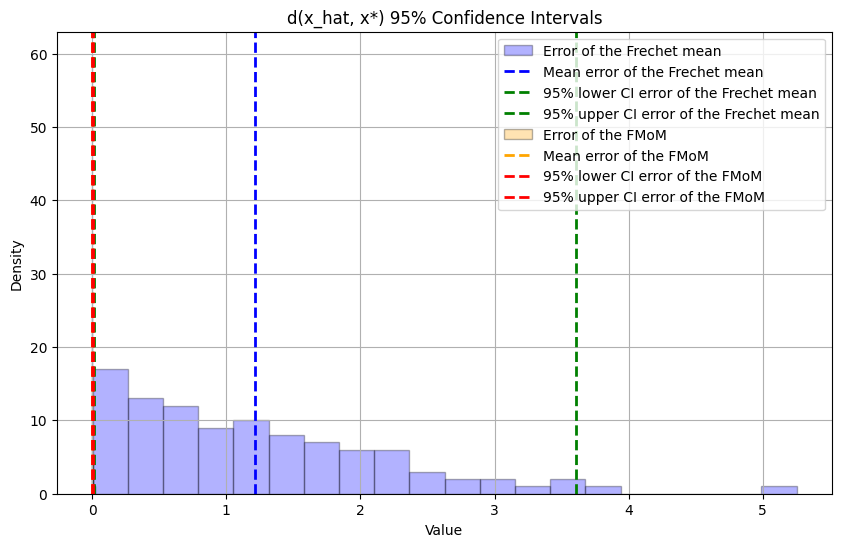

In [45]:
# Create an illustrative figure
plt.figure(figsize=(10, 6))

# Histogram for the original estimator
plt.hist(ind_mean_err_list, bins=20, alpha=0.3, color='blue', edgecolor='black', density=False, label='Error of the Frechet mean')
plt.axvline(mean_ind_esti_err, color='blue', linestyle='dashed', linewidth=2, label='Mean error of the Frechet mean')
plt.axvline(ci_ind_esti_err[0], color='green', linestyle='dashed', linewidth=2, label='95% lower CI error of the Frechet mean')
plt.axvline(ci_ind_esti_err[1], color='green', linestyle='dashed', linewidth=2, label='95% upper CI error of the Frechet mean')

# Histogram for FMoM
plt.hist(ind_mom_err_list, bins=20, alpha=0.3, color='orange', edgecolor='black', density=False, label='Error of the FMoM')
plt.axvline(mean_mom_esti_err, color='orange', linestyle='dashed', linewidth=2, label='Mean error of the FMoM')
plt.axvline(ci_mom_esti_err[0], color='red', linestyle='dashed', linewidth=2, label='95% lower CI error of the FMoM')
plt.axvline(ci_mom_esti_err[1], color='red', linestyle='dashed', linewidth=2, label='95% upper CI error of the FMoM')


# Set x-axis limits (adjust these as necessary)
# plt.xlim(-0.05, 2)

# Add labels and title
plt.title('d(x_hat, x*) 95% Confidence Intervals')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [46]:
# error and squared error for results
print(statistics.fmean(ind_mean_err_list))
print(statistics.fmean(ind_mom_err_list))
print(statistics.fmean(ind_mean_err_sq_list))
print(statistics.fmean(ind_mom_err_sq_list))

1.213338765400057
0.0023282218214757105
2.4863922439440107
1.4541324031297118e-05


Visualization

r0: 1.8847054724843684
r1: 0.001998307462860946


<ipython-input-47-d2228c94e494>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_x[i] = data.coord
<ipython-input-47-d2228c94e494>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_y[i] = np.tan(2 * np.pi * data.stratum / num_ray) * data.coord


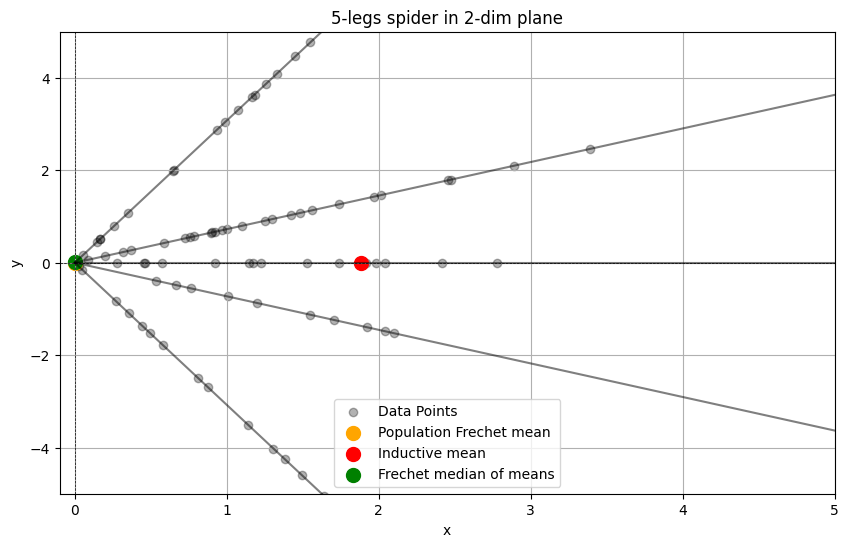

In [47]:
# embed into R^2
leg_list = range(num_ray)
print(mean_inductive)
print(med_of_ind_means)
# Set up the plot
plt.figure(figsize=(10, 6))
x = np.linspace(0, 150, 1000)  # x from 0 to 10
for k in leg_list:
    # Calculate y values using the given function
    y = np.tan(2 * np.pi * k / num_ray) * x
    plt.plot(x, y, alpha = 0.5, color = "black")
# Set limits and labels
data_x = np.zeros(num_sample)
data_y = np.zeros(num_sample)
for i, data in enumerate(spider_data):
  data_x[i] = data.coord
  data_y[i] = np.tan(2 * np.pi * data.stratum / num_ray) * data.coord
# Scatter the points on the plot
plt.scatter(data_x, data_y, color='black', label='Data Points', alpha = 0.3)
# Population Frechet mean
plt.scatter(0.0, 0.0, color = "orange", s = 100, alpha = 1, label = "Population Frechet mean")
# the original estimator
mean_inductive_y = np.tan(2 * np.pi * mean_inductive.stratum / num_ray) * mean_inductive.coord
plt.scatter(mean_inductive.coord, mean_inductive_y, color='red',label='Inductive mean', alpha = 1, s = 100)
# FMoM
mom_y = np.tan(2 * np.pi * med_of_ind_means.stratum / num_ray) * med_of_ind_means.coord
plt.scatter(med_of_ind_means.coord, mom_y, color='green', label='Frechet median of means', alpha = 1, s = 100)
# extra setting for the plots
plt.ylim(-5, 5)  # Limit y-axis to prevent too steep lines from going off
plt.xlim(-0.1, 5)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.title('5-legs spider in 2-dim plane')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

## Experiment 1-appendix: Poincare disk Freceht mean estimation

Hyperparameter settings

In [67]:
# hyperparam setting
d = 2 # dimension
tail_portion = 0.5 # portion of tail (i.e. outlying) samples -> very heavy tail
num_samples = 100 # total number of samples
num_samples_outlier = int(num_samples * tail_portion) # outlier samples
num_samples_non_outlier = num_samples - num_samples_outlier # non-outlier samples
poincare_ball = PoincareBall(dim = d) # base model
sd_nontail = 0.2 # sd for the distribution of nontail
norm_tail = (1-(1e-07)) # norm of the random variable on the tail
# mean for the nonoutlier data
mean_original = np.array([0,0])
k = 50 # num of blocks

Simulation: Freceht mean estimation in Poincare disk

In [68]:
# random.seed(10)
num_simulation = 100 # number of simulations to conduct

plain_estimator_err_list = []
mom_estimator_err_list = []
plain_estimator_sq_err_list = []
mom_estimator_sq_err_list = []

for j in range(num_simulation):
  if j % 10 == 0:
    print("conducting " + str(j+1) + "th simulation...")
  data_nonoutlier_before_proj = np.random.normal(0.0, sd_nontail, size = (num_samples_non_outlier, d)) # nontail part -> Gaussian
  data_nonoutlier = poincare_ball.projection(data_nonoutlier_before_proj)
  # tail part -> uniform on the Sphere of radius = norm_tail
  sphere = Hypersphere(dim=(d-1))
  data_outlier_sphere = sphere.random_uniform(num_samples_outlier)
  data_outlier = data_outlier_sphere * norm_tail
  # concat two data
  data_total = np.concatenate((data_nonoutlier, data_outlier))
  data_total = np.random.permutation(data_total) # to ensure iid condition for each estimators -> for inductive mean
  # empirical frechet mean
  # mean_frechet = FrechetMean(poincare_ball)
  # mean_frechet.fit(data_total)
  # mean_frechet_esti = mean_frechet.estimate_
  mean_frechet_esti = inductive_mean(data_total, metric_space = poincare_ball)
  # mom estimator
  data_splitted = np.array_split(data_total, k)
  block_esti = []
  for i in range(k):
    block_esti.append(inductive_mean(data_splitted[i], metric_space = poincare_ball))
  block_esti_arr = np.array(block_esti)
  frechet_med = GeometricMedian(poincare_ball)
  frechet_med.fit(block_esti_arr)
  med_of_esti = frechet_med.estimate_
  # # measure the error: distance or squared distance?
  plain_estimator_err = poincare_ball.metric.dist(mean_original, mean_frechet_esti)
  mom_estimator_err = poincare_ball.metric.dist(mean_original, med_of_esti)
  plain_estimator_sq_err = poincare_ball.metric.squared_dist(mean_original, mean_frechet_esti)
  mom_estimator_sq_err = poincare_ball.metric.squared_dist(mean_original, med_of_esti)
  # append the result
  plain_estimator_err_list.append(plain_estimator_err)
  mom_estimator_err_list.append(mom_estimator_err)
  plain_estimator_sq_err_list.append(plain_estimator_sq_err)
  mom_estimator_sq_err_list.append(mom_estimator_sq_err)
  # print("time elapsed: " + str(int(time.time() - start_time)) + "s")


# Calculate mean and confidence intervals for both datasets
mean_plain_esti_err, ci_plain_esti_err = confidence_interval(plain_estimator_err_list)
mean_mom_esti_err, ci_mom_esti_err = confidence_interval(mom_estimator_err_list)

conducting 1th simulation...
conducting 11th simulation...
conducting 21th simulation...
conducting 31th simulation...
conducting 41th simulation...
conducting 51th simulation...


conducting 61th simulation...


conducting 71th simulation...
conducting 81th simulation...
conducting 91th simulation...


Results

In [69]:
print("Poincare ball FMoM results")
print(f"d Error of the empirical Frechet mean: Mean: {mean_plain_esti_err:.2f}, 95% Confidence Interval: {ci_plain_esti_err}")
print(f"d Error of the FMoM: Mean: {mean_mom_esti_err:.2f}, 95% Confidence Interval: {ci_mom_esti_err}")
print(statistics.fmean(plain_estimator_err_list))
print(statistics.fmean(mom_estimator_err_list))
print(statistics.fmean(plain_estimator_sq_err_list))
print(statistics.fmean(mom_estimator_sq_err_list))

Poincare ball FMoM results
d Error of the empirical Frechet mean: Mean: 0.36, 95% Confidence Interval: [0.07449345 0.78167724]
d Error of the FMoM: Mean: 0.15, 95% Confidence Interval: [0.014972   0.27273062]
0.3559936697061218
0.1451588344717345
0.16289052317928007
0.0658996786432567


Plot CI

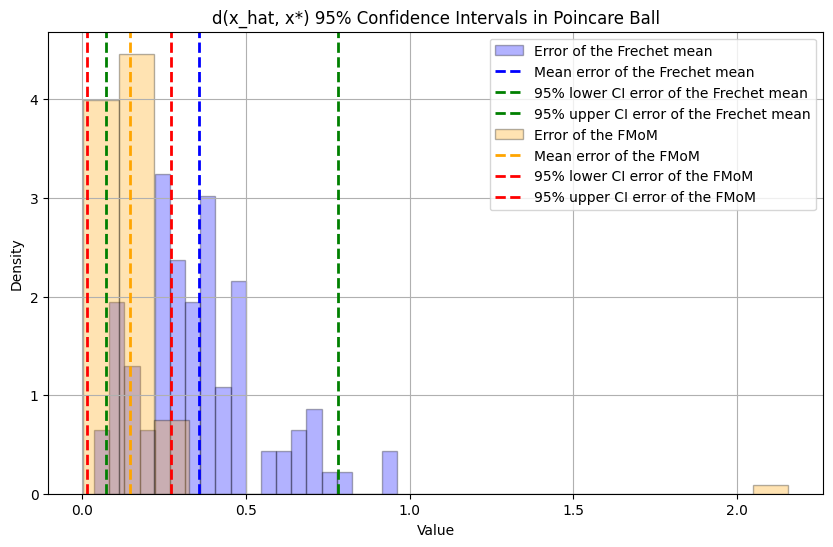

In [70]:
# Create an illustrative figure
plt.figure(figsize=(10, 6))

# Histogram for the original estimator
plt.hist(plain_estimator_err_list, bins=20, alpha=0.3, color='blue', edgecolor='black', density=True, label='Error of the Frechet mean')
plt.axvline(mean_plain_esti_err, color='blue', linestyle='dashed', linewidth=2, label='Mean error of the Frechet mean')
plt.axvline(ci_plain_esti_err[0], color='green', linestyle='dashed', linewidth=2, label='95% lower CI error of the Frechet mean')
plt.axvline(ci_plain_esti_err[1], color='green', linestyle='dashed', linewidth=2, label='95% upper CI error of the Frechet mean')

# Histogram for FMoM
plt.hist(mom_estimator_err_list, bins=20, alpha=0.3, color='orange', edgecolor='black', density=True, label='Error of the FMoM')
plt.axvline(mean_mom_esti_err, color='orange', linestyle='dashed', linewidth=2, label='Mean error of the FMoM')
plt.axvline(ci_mom_esti_err[0], color='red', linestyle='dashed', linewidth=2, label='95% lower CI error of the FMoM')
plt.axvline(ci_mom_esti_err[1], color='red', linestyle='dashed', linewidth=2, label='95% upper CI error of the FMoM')


# Set x-axis limits (adjust these as necessary)
#plt.xlim(-0.05, 2)

# Add labels and title
plt.title('d(x_hat, x*) 95% Confidence Intervals in Poincare Ball')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()

# Show the plot
plt.show()

Plot result for visualization

Plot the Frechet mean

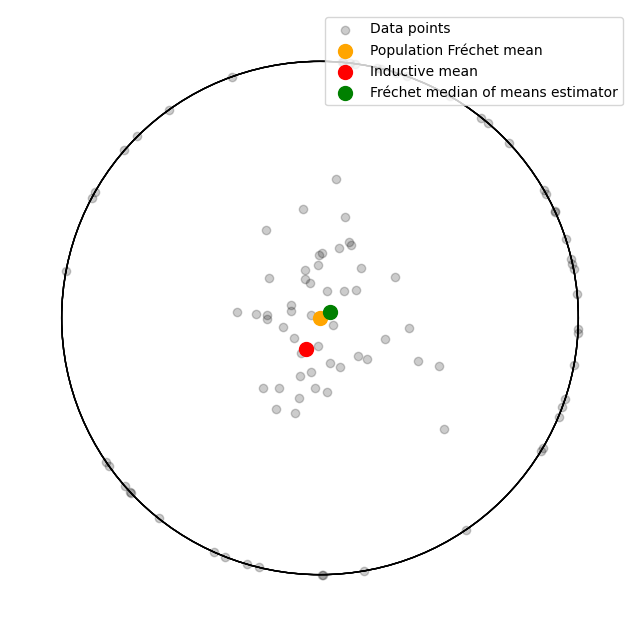

In [71]:
fig = plt.figure(figsize=(8, 8))
ax = visualization.plot(data_total, space="H2_poincare_disk", color="black", coords_type='ball',alpha=0.2, label="Data points")
ax = visualization.plot(
    mean_original, space="H2_poincare_disk", color="orange", ax=ax, s=100, coords_type = 'ball', label="Population Fréchet mean"
)
ax = visualization.plot(
    mean_frechet_esti, space="H2_poincare_disk", color="red", ax=ax, s=100, coords_type = 'ball', label="Inductive mean"
)
ax = visualization.plot(
    med_of_esti, space="H2_poincare_disk", color="green", ax=ax, s=100, coords_type = 'ball', label="Fréchet median of means estimator"
)
ax.legend(loc = 1);

# plot geodesic curve connecting two points, if needed
# geod_fun1 = poincare_ball.metric.geodesic(initial_point = mean_original, end_point = mean_frechet_esti)
# geod_fun2 = poincare_ball.metric.geodesic(initial_point = mean_original, end_point = med_of_esti)
# n_steps = 100
# t = gs.linspace(0, 1.0, n_steps)
# geodesic_points_0 = geod_fun1(t)
# geodesic_points_1 = geod_fun2(t)
# ax = visualization.plot(
#     geodesic_points_0, ax, space="H2_poincare_disk", linewidth=0.01, coords_type = 'ball', color="black"
# )
# ax = visualization.plot(
#     geodesic_points_1, ax, space="H2_poincare_disk", linewidth=0.01 ,coords_type = 'ball', color="black"
# )

## Experiment 2: SPD matrix with Affine Invariant metric and BW metric

Hyperparameter settings

In [62]:
# hyperparam setting
d = 10 # dimension
# num_sample = 10 * pow(d, 4) # total number of samples
num_sample = 100000 # total number of samples
# num_sample = 1000 # total number of samples
spd_mat_space = SPDMatrices(n = d) # base model for AI metric
bw_space = SPDMatrices(n = d, equip = False) # base model for BW metric
bw_space.equip_with_metric(SPDBuresWassersteinMetric)
k = 5 # num of blocks
nu = 2.5 # df for t-distribution
lambda_min = 1

Simulation

In [ ]:
#random.seed(10)
num_simulation = 100 # number of simulations to conduct

plain_estimator_err_list_ai = []
plain_estimator_err_list_bw = []
mom_estimator_err_list_ai = []
mom_estimator_err_list_bw = []
plain_estimator_sq_err_list_ai = []
plain_estimator_sq_err_list_bw = []
mom_estimator_sq_err_list_ai = []
mom_estimator_sq_err_list_bw = []

avg_time_ori = []
avg_time_ai = []
avg_time_bw = []

for j in range(num_simulation):
  if j % 50 == 0:
    print("conducting " + str(j+1) + "th simulation...")
  true_cov = gen_matrix_with_eigbounds(lambda_min, d * lambda_min, d) # generate cov matrix
  true_target = (nu / (nu - 2)) * true_cov # cov matrix for t_nu dist
  # generate data: heavy tail t-distribution
  data_total = multivariate_t.rvs(loc = np.zeros(d), shape = true_cov, df = nu, size = num_sample)
  start_time = time.time()
  # plain estimator
  plain_esti = np.einsum('ij,ik->jk', data_total, data_total) / (num_sample-1)
  avg_time_ori.append(time.time() - start_time)
  # mom
  start_time = time.time()
  data_splitted = np.array_split(data_total, k)
  block_esti = []
  for i in range(k):
    block_plain_esti = np.einsum('ij,ik->jk', data_splitted[i], data_splitted[i]) / (len(data_splitted[i])-1)
    block_esti.append(block_plain_esti)
  block_esti_arr = np.array(block_esti)
  # med_of_esti = cyclic_med(block_esti_arr, init_value=block_esti_arr[0], metric_space = spd_mat_space, num_step = 100)
  # Use geometric median function in Geomstats
  frechet_med_ai = GeometricMedian(spd_mat_space)
  frechet_med_ai.fit(block_esti_arr)
  med_of_esti_ai = frechet_med_ai.estimate_
  avg_time_ai.append(time.time() - start_time)
  start_time = time.time()
  data_splitted = np.array_split(data_total, k)
  block_esti = []
  for i in range(k):
    block_plain_esti = np.einsum('ij,ik->jk', data_splitted[i], data_splitted[i]) / (len(data_splitted[i])-1)
    block_esti.append(block_plain_esti)
  block_esti_arr = np.array(block_esti)
  frechet_med_bw = GeometricMedian(bw_space)
  frechet_med_bw.fit(block_esti_arr)
  med_of_esti_bw = frechet_med_bw.estimate_
  avg_time_bw.append(time.time() - start_time)
  # collect error
  plain_estimator_err_ai = spd_mat_space.metric.dist(true_target, plain_esti)
  plain_estimator_err_bw = bw_space.metric.dist(true_target, plain_esti)
  mom_estimator_err_ai = spd_mat_space.metric.dist(true_target, med_of_esti_ai)
  mom_estimator_err_bw = bw_space.metric.dist(true_target, med_of_esti_bw)
  plain_estimator_sq_err_ai = spd_mat_space.metric.squared_dist(true_target, plain_esti)
  plain_estimator_sq_err_bw = bw_space.metric.squared_dist(true_target, plain_esti)
  mom_estimator_sq_err_ai = spd_mat_space.metric.squared_dist(true_target, med_of_esti_ai)
  mom_estimator_sq_err_bw = bw_space.metric.squared_dist(true_target, med_of_esti_bw)
  # append the result
  plain_estimator_err_list_ai.append(plain_estimator_err_ai)
  plain_estimator_err_list_bw.append(plain_estimator_err_bw)
  mom_estimator_err_list_ai.append(mom_estimator_err_ai)
  mom_estimator_err_list_bw.append(mom_estimator_err_bw)
  plain_estimator_sq_err_list_ai.append(plain_estimator_sq_err_ai)
  plain_estimator_sq_err_list_bw.append(plain_estimator_sq_err_bw)
  mom_estimator_sq_err_list_ai.append(mom_estimator_sq_err_ai)
  mom_estimator_sq_err_list_bw.append(mom_estimator_sq_err_bw)
# print("time elapsed: " + str(int(time.time() - start_time)) + "s")


# Calculate mean and confidence intervals for both datasets
mean_plain_esti_err_ai, ci_plain_esti_err_ai = confidence_interval(plain_estimator_err_list_ai)
mean_mom_esti_err_ai, ci_mom_esti_err_ai = confidence_interval(mom_estimator_err_list_ai)
mean_plain_esti_err_bw, ci_plain_esti_err_bw = confidence_interval(plain_estimator_err_list_bw)
mean_mom_esti_err_bw, ci_mom_esti_err_bw = confidence_interval(mom_estimator_err_list_bw)

Results

In [64]:
print("d_AI results")
print(f"d_AI Error of the sample covariance: Mean: {mean_plain_esti_err_ai:.2f}, 95% Confidence Interval: {ci_plain_esti_err_ai}")
print(f"d_AI Error of the FMoE: Mean: {mean_mom_esti_err_ai:.2f}, 95% Confidence Interval: {ci_mom_esti_err_ai}")
print(statistics.fmean(plain_estimator_err_list_ai))
print(statistics.fmean(mom_estimator_err_list_ai))
print(statistics.fmean(plain_estimator_sq_err_list_ai))
print(statistics.fmean(mom_estimator_sq_err_list_ai))
print("d_BW results")
print(f"d_BW Error of the sample covariance: Mean: {mean_plain_esti_err_bw:.2f}, 95% Confidence Interval: {ci_plain_esti_err_bw}")
print(f"d_BW Error of the FMoE: Mean: {mean_mom_esti_err_bw:.2f}, 95% Confidence Interval: {ci_mom_esti_err_bw}")
print(statistics.fmean(plain_estimator_err_list_bw))
print(statistics.fmean(mom_estimator_err_list_bw))
print(statistics.fmean(plain_estimator_sq_err_list_bw))
print(statistics.fmean(mom_estimator_sq_err_list_bw))
print("Time analysis")
print(statistics.fmean(avg_time_ori))
print(statistics.fmean(avg_time_ai))
print(statistics.fmean(avg_time_bw))

d_AI results
d_AI Error of the sample covariance: Mean: 0.60, 95% Confidence Interval: [0.42429473 1.04704645]
d_AI Error of the FMoE: Mean: 0.54, 95% Confidence Interval: [0.41883331 0.6798952 ]
0.6031889173144871
0.5370503307292479
0.3937165297340362
0.29344435331032825
d_BW results
d_BW Error of the sample covariance: Mean: 1.56, 95% Confidence Interval: [1.04910202 3.02306747]
d_BW Error of the FMoE: Mean: 1.30, 95% Confidence Interval: [0.95022243 1.72494594]
1.5576798432146859
1.2962603042333567
2.8507208284198255
1.7249940158256407
Time analysis
0.018433165550231934
0.08806522846221924
0.1320578622817993


Plot confidence interval

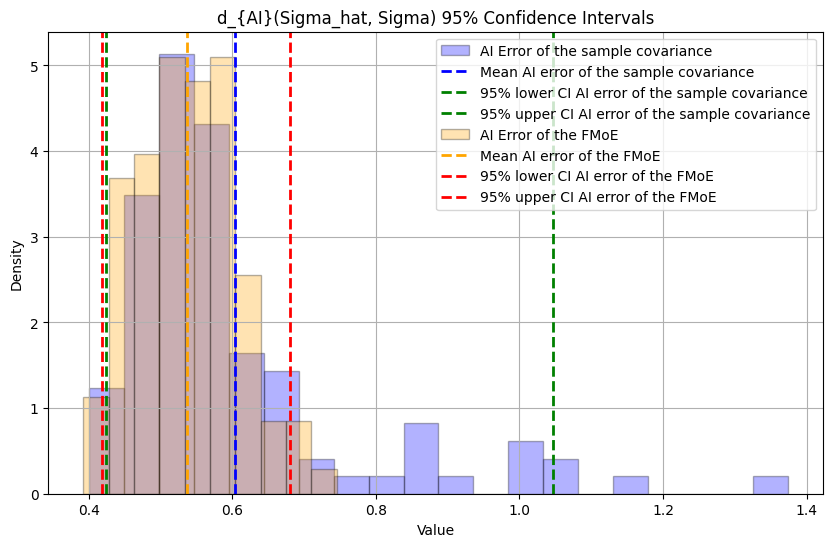

In [65]:
# Create an illustrative figure
plt.figure(figsize=(10, 6))

# Histogram for data1
plt.hist(plain_estimator_err_list_ai, bins=20, alpha=0.3, color='blue', edgecolor='black', density=True, label='AI Error of the sample covariance')
plt.axvline(mean_plain_esti_err_ai, color='blue', linestyle='dashed', linewidth=2, label='Mean AI error of the sample covariance')
plt.axvline(ci_plain_esti_err_ai[0], color='green', linestyle='dashed', linewidth=2, label='95% lower CI AI error of the sample covariance')
plt.axvline(ci_plain_esti_err_ai[1], color='green', linestyle='dashed', linewidth=2, label='95% upper CI AI error of the sample covariance')

# Histogram for data2
plt.hist(mom_estimator_err_list_ai, alpha=0.3, color='orange', edgecolor='black', density=True, label='AI Error of the FMoE')
plt.axvline(mean_mom_esti_err_ai, color='orange', linestyle='dashed', linewidth=2, label='Mean AI error of the FMoE')
plt.axvline(ci_mom_esti_err_ai[0], color='red', linestyle='dashed', linewidth=2, label='95% lower CI AI error of the FMoE')
plt.axvline(ci_mom_esti_err_ai[1], color='red', linestyle='dashed', linewidth=2, label='95% upper CI AI error of the FMoE')

# Set x-axis limits (adjust these as necessary)
# plt.xlim(0.3, 1.3)

# Add labels and title
plt.title('d_{AI}(Sigma_hat, Sigma) 95% Confidence Intervals')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()

# Show the plot
plt.show()

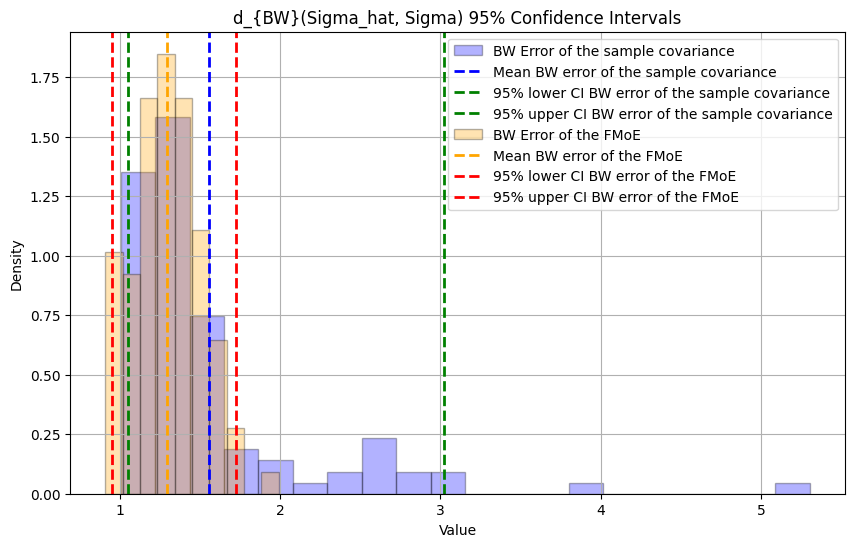

In [66]:
# Create an illustrative figure
plt.figure(figsize=(10, 6))

# Histogram for data1
plt.hist(plain_estimator_err_list_bw, bins=20, alpha=0.3, color='blue', edgecolor='black', density=True, label='BW Error of the sample covariance')
plt.axvline(mean_plain_esti_err_bw, color='blue', linestyle='dashed', linewidth=2, label='Mean BW error of the sample covariance')
plt.axvline(ci_plain_esti_err_bw[0], color='green', linestyle='dashed', linewidth=2, label='95% lower CI BW error of the sample covariance')
plt.axvline(ci_plain_esti_err_bw[1], color='green', linestyle='dashed', linewidth=2, label='95% upper CI BW error of the sample covariance')

# Histogram for data2
plt.hist(mom_estimator_err_list_bw, alpha=0.3, color='orange', edgecolor='black', density=True, label='BW Error of the FMoE')
plt.axvline(mean_mom_esti_err_bw, color='orange', linestyle='dashed', linewidth=2, label='Mean BW error of the FMoE')
plt.axvline(ci_mom_esti_err_bw[0], color='red', linestyle='dashed', linewidth=2, label='95% lower CI BW error of the FMoE')
plt.axvline(ci_mom_esti_err_bw[1], color='red', linestyle='dashed', linewidth=2, label='95% upper CI BW error of the FMoE')

# Set x-axis limits (adjust these as necessary)
# plt.xlim(0.3, 1.3)


# Add labels and title
plt.title('d_{BW}(Sigma_hat, Sigma) 95% Confidence Intervals')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid()

# Show the plot
plt.show()